Mounted at /content/drive
Checking GPU availability...
GPU is available!

Checking dataset at: /content/drive/MyDrive/CS471_AI/FinalProject/MangoDataset_Balanced

=== Training Gradient Boosting Classifier ===
Creating data generators...
Found 5200 images belonging to 4 classes.
Found 1120 images belonging to 4 classes.
Found 1120 images belonging to 4 classes.
Extracting features from images...
12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Extracting batch 163/163
Extracting batch 35/35
Extracting batch 35/35

Applying PCA dimensionality reduction...
Original feature dimensions: 960
Reduced feature dimensions: 168
Variance retained: 95.03%

Training Gradient Boosting Classifier...
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1362           0.2493            1.37m
         2           0.9534           0.1789            1.29m
         3           0.8125           0.1439            1.25m
         4           0.6981           0.1116            

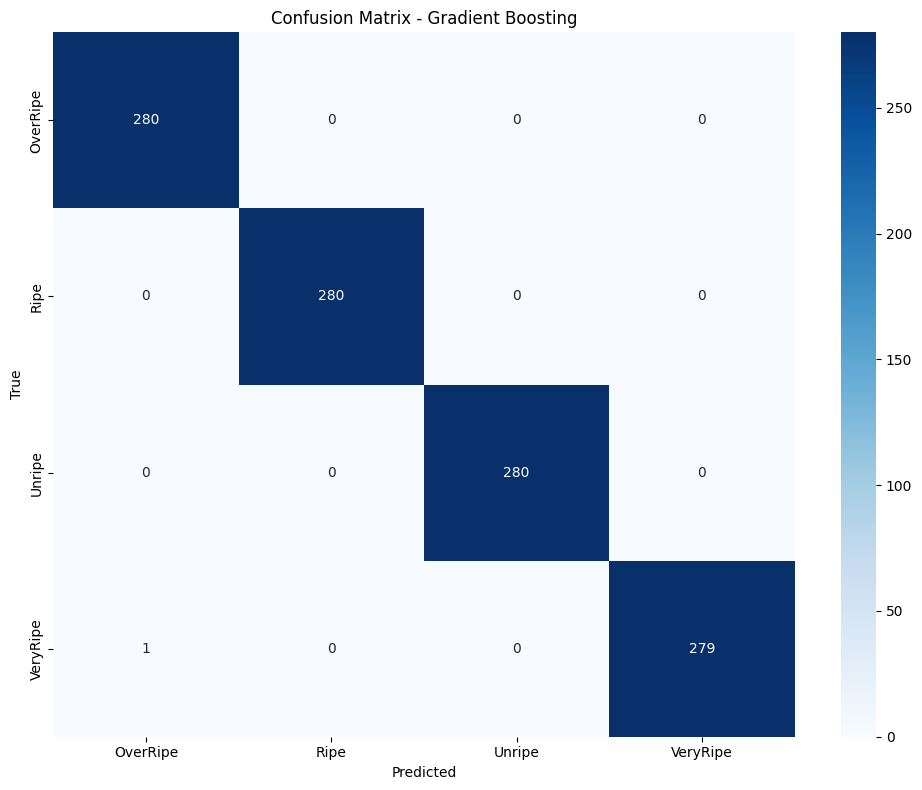

<ipython-input-1-b8605a4f389f>:225: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')


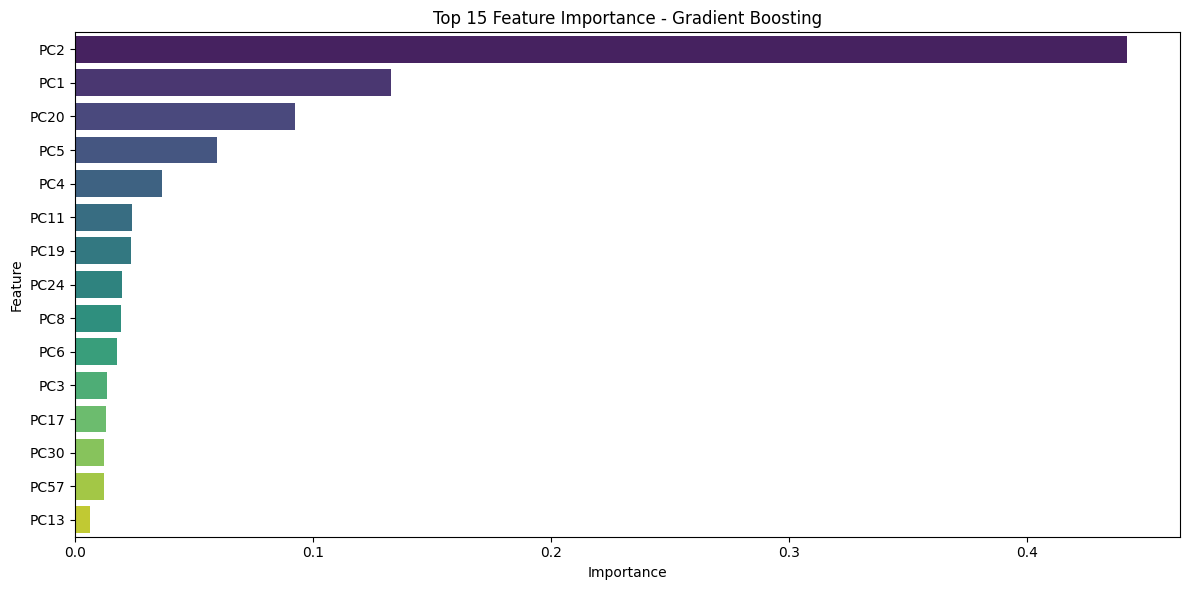

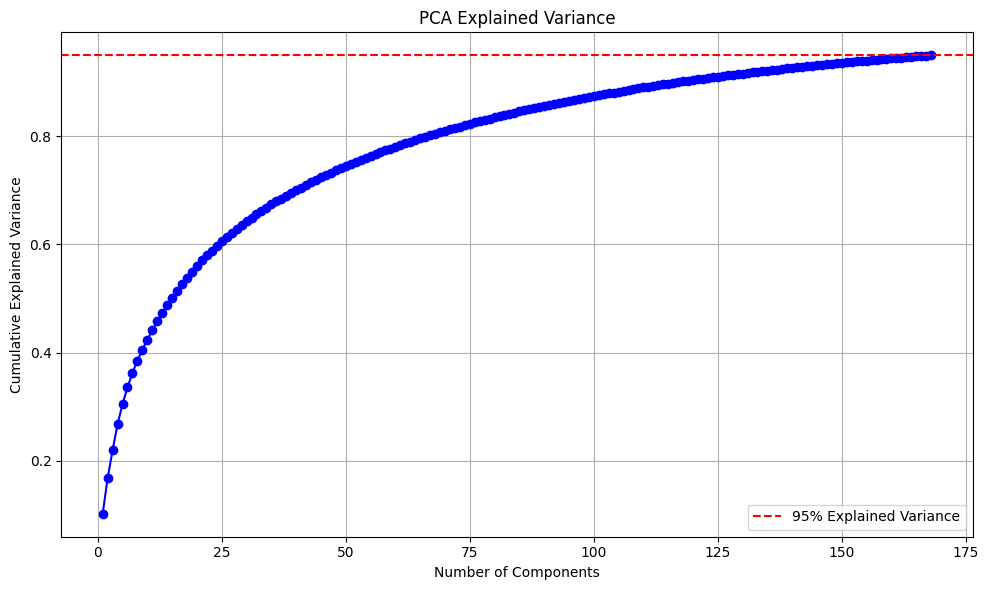

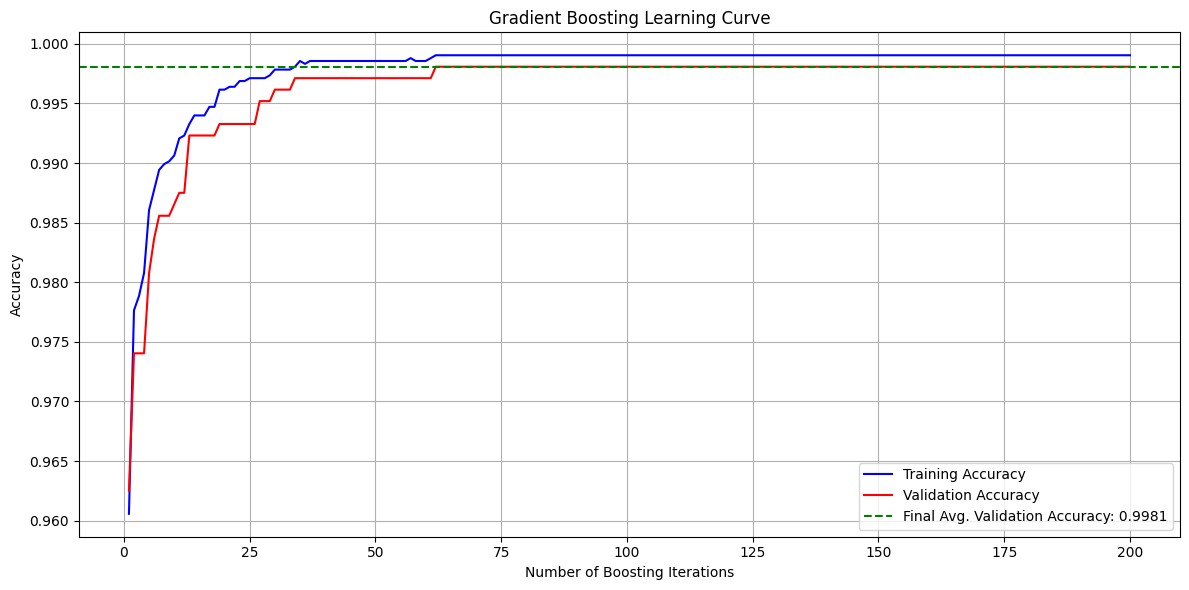

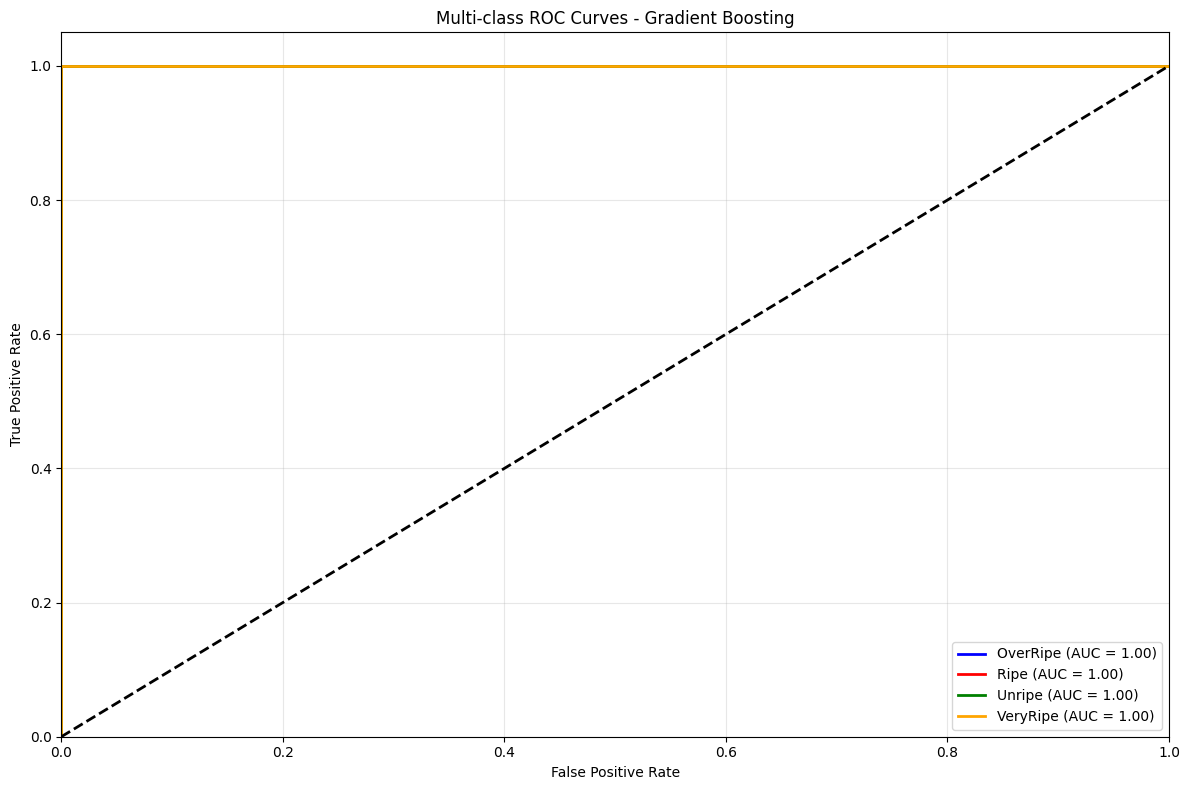


Generating t-SNE visualization...


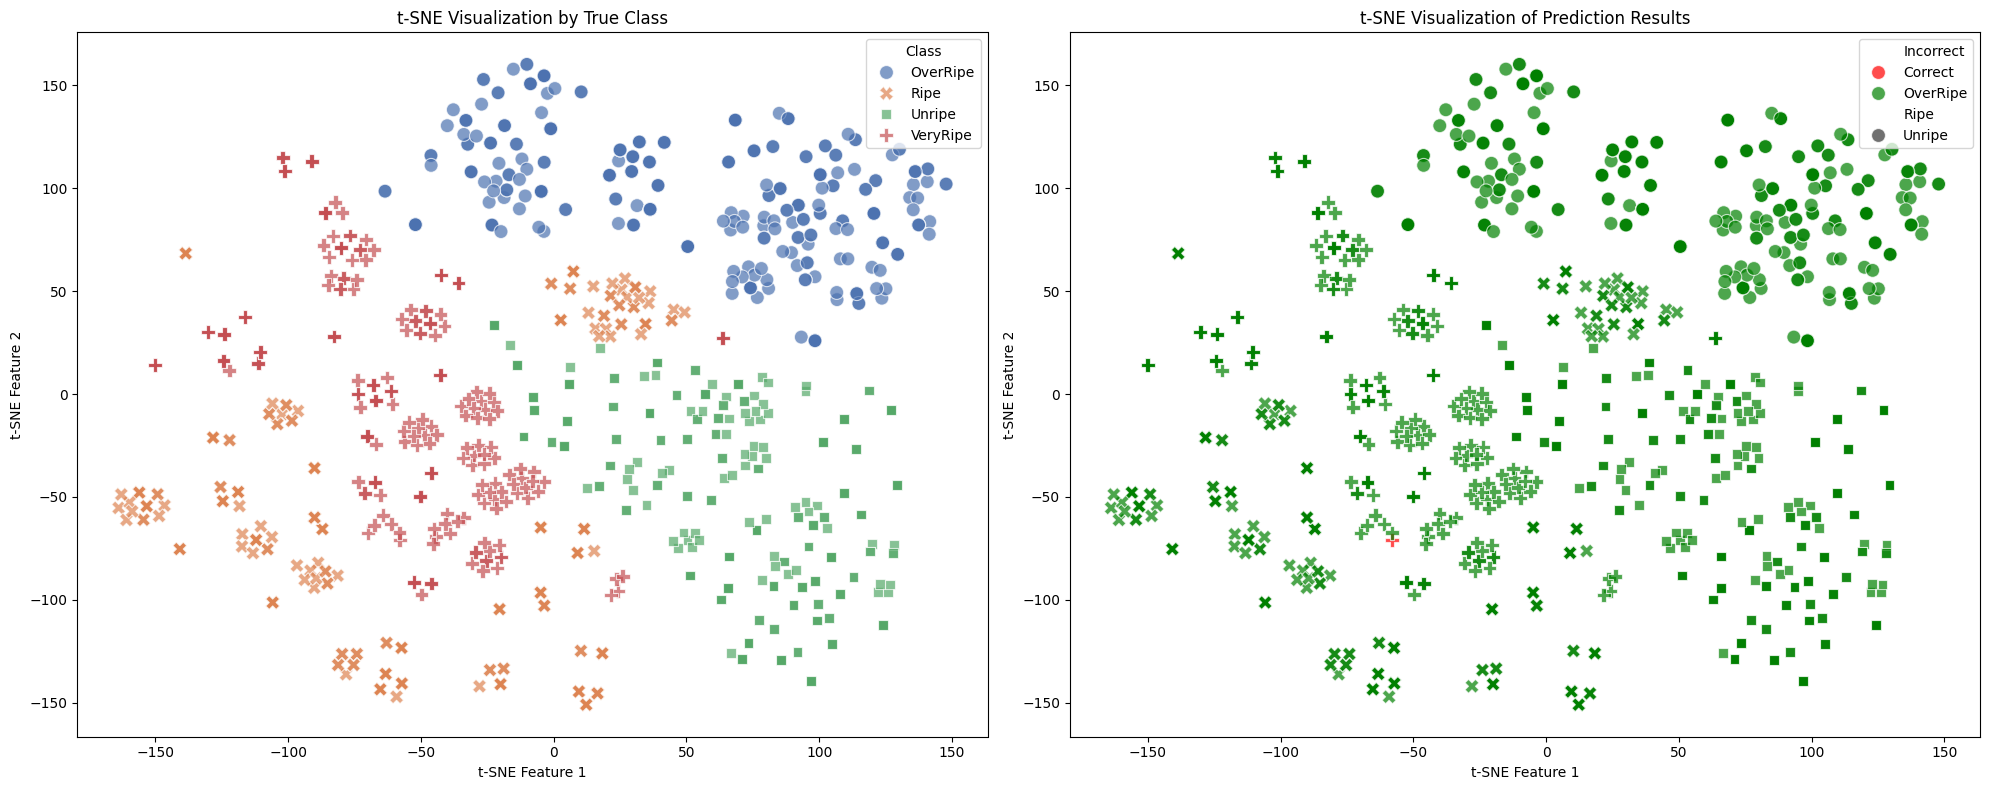

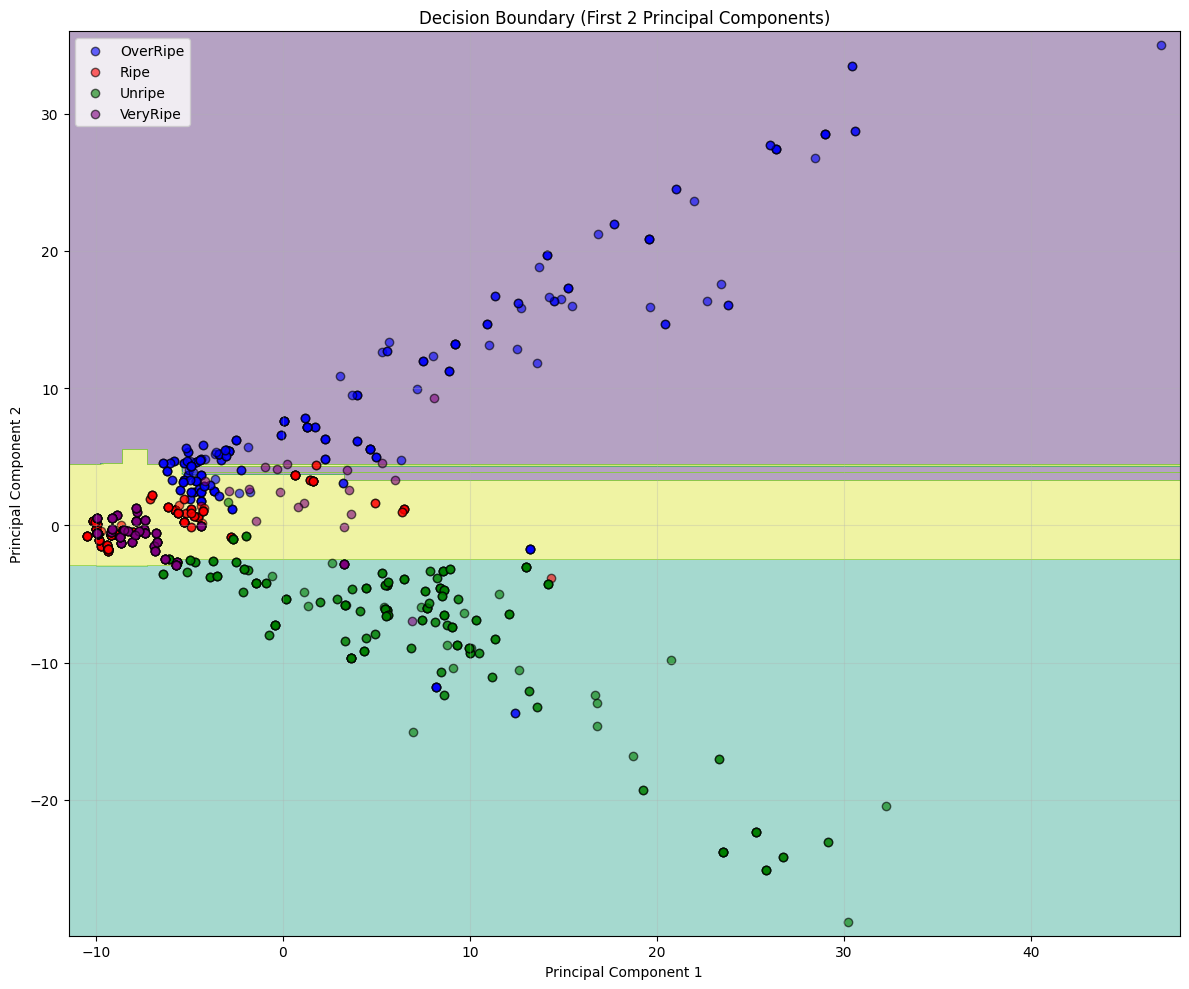


Training completed in 4637.29 seconds
Gradient Boosting training and evaluation complete!


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from sklearn.manifold import TSNE
import time
import tensorflow as tf
from google.colab import drive

def gradient_boosting_train(base_path, n_estimators=200, learning_rate=0.1, max_depth=3):
    """
    Train a Gradient Boosting classifier on the mango dataset with enhanced visualizations

    Args:
        base_path (str): Dataset root path
        n_estimators (int): Number of boosting stages
        learning_rate (float): Learning rate
        max_depth (int): Maximum depth of trees

    Returns:
        tuple: (model, features, labels, feature_names)
    """
    print("\n=== Training Gradient Boosting Classifier ===")
    start_time = time.time()

    # Define image size and categories
    img_size = (224, 224)
    categories = ['OverRipe', 'Ripe', 'Unripe', 'VeryRipe']

    # Prepare data generators without augmentation (for feature extraction)
    datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input)

    # Create generators for feature extraction
    print("Creating data generators...")
    train_generator = datagen.flow_from_directory(
        os.path.join(base_path, 'train'),
        target_size=img_size,
        batch_size=32,
        class_mode='categorical',
        shuffle=False,  # Important for keeping track of labels
        classes=categories
    )

    valid_generator = datagen.flow_from_directory(
        os.path.join(base_path, 'valid'),
        target_size=img_size,
        batch_size=32,
        class_mode='categorical',
        shuffle=False,
        classes=categories
    )

    test_generator = datagen.flow_from_directory(
        os.path.join(base_path, 'test'),
        target_size=img_size,
        batch_size=32,
        class_mode='categorical',
        shuffle=False,
        classes=categories
    )

    # Feature extraction using a pre-trained model
    print("Extracting features from images...")
    base_model = tf.keras.applications.MobileNetV3Large(
        input_shape=img_size + (3,),
        include_top=False,
        weights='imagenet',
        pooling='avg'  # Global average pooling for feature extraction
    )

    # Extract features and labels
    def extract_features_labels(generator):
        features = []
        labels = []

        # Get the total number of samples
        num_samples = generator.samples
        num_batches = int(np.ceil(num_samples / generator.batch_size))

        # Reset the generator internal index
        generator.reset()

        for i in range(num_batches):
            print(f"\rExtracting batch {i+1}/{num_batches}", end="")

            # Get the next batch
            batch = next(generator)
            x_batch, y_batch = batch

            # Extract features using the model
            batch_features = base_model.predict(x_batch, verbose=0)

            # Store
            features.append(batch_features)
            labels.append(y_batch)

        print()  # New line after progress

        # Concatenate batches
        features = np.concatenate(features, axis=0)
        labels = np.concatenate(labels, axis=0)

        # Ensure we only take valid samples (in case the last batch was partially filled)
        features = features[:num_samples]
        labels = labels[:num_samples]

        # Convert one-hot encoded labels to class indices
        labels = np.argmax(labels, axis=1)

        return features, labels

    # Extract features for each set
    train_features, train_labels = extract_features_labels(train_generator)
    valid_features, valid_labels = extract_features_labels(valid_generator)
    test_features, test_labels = extract_features_labels(test_generator)

    # Apply PCA for dimensionality reduction (retain 95% variance)
    print("\nApplying PCA dimensionality reduction...")
    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_features)
    valid_features_scaled = scaler.transform(valid_features)
    test_features_scaled = scaler.transform(test_features)

    pca = PCA(n_components=0.95)  # Retain 95% of variance
    train_features_pca = pca.fit_transform(train_features_scaled)
    valid_features_pca = pca.transform(valid_features_scaled)
    test_features_pca = pca.transform(test_features_scaled)

    print(f"Original feature dimensions: {train_features.shape[1]}")
    print(f"Reduced feature dimensions: {train_features_pca.shape[1]}")
    print(f"Variance retained: {sum(pca.explained_variance_ratio_) * 100:.2f}%")

    # Create and train the Gradient Boosting model
    print("\nTraining Gradient Boosting Classifier...")
    gb_model = GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        random_state=42,
        subsample=0.8,  # Use 80% of samples for each tree (prevents overfitting)
        verbose=1  # Show progress
    )

    gb_model.fit(train_features_pca, train_labels)

    # Evaluate on validation set
    valid_predictions = gb_model.predict(valid_features_pca)
    valid_accuracy = accuracy_score(valid_labels, valid_predictions)
    print(f"\nValidation Accuracy: {valid_accuracy:.4f}")

    # Evaluate on test set
    test_predictions = gb_model.predict(test_features_pca)
    test_accuracy = accuracy_score(test_labels, test_predictions)
    print(f"\nTest Accuracy: {test_accuracy:.4f}")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(test_labels, test_predictions,
                              target_names=categories))

    # VISUALIZATION 1: Confusion matrix
    plot_confusion_matrix(test_labels, test_predictions, categories)

    # VISUALIZATION 2: Feature importance
    plot_feature_importance(gb_model, pca, 15)

    # VISUALIZATION 3: Learning curve (showing training progress)
    plot_learning_curve(gb_model, train_features_pca, train_labels)

    # VISUALIZATION 4: ROC curves
    plot_roc_curves(gb_model, test_features_pca, test_labels, categories)

    # VISUALIZATION 5: t-SNE scatter plot
    plot_tsne_scatter(test_features_pca, test_labels, test_predictions, categories)

    # VISUALIZATION 6: Decision boundary visualization (for top 2 PCA components)
    plot_decision_boundary(gb_model, test_features_pca, test_labels, categories)

    print(f"\nTraining completed in {time.time() - start_time:.2f} seconds")

    return gb_model, test_features_pca, test_labels, gb_model.feature_importances_

def plot_confusion_matrix(y_true, y_pred, classes):
    """
    Plot confusion matrix for Gradient Boosting results
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Gradient Boosting')
    plt.tight_layout()
    plt.savefig('gb_confusion_matrix.png')
    plt.show()

def plot_feature_importance(model, pca, top_n=15):
    """
    Plot feature importance from Gradient Boosting
    """
    # Get feature importance
    importances = model.feature_importances_

    # Create DataFrame for plotting
    feature_names = [f"PC{i+1}" for i in range(len(importances))]
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False)

    # Take top N features
    top_features = importance_df.head(top_n)

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
    plt.title(f'Top {top_n} Feature Importance - Gradient Boosting')
    plt.tight_layout()
    plt.savefig('gb_feature_importance.png')
    plt.show()

    # Show explained variance by top components
    plt.figure(figsize=(10, 6))
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='b')
    plt.grid(True)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance')
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
    plt.legend()
    plt.tight_layout()
    plt.savefig('gb_pca_variance.png')
    plt.show()

def plot_learning_curve(model, X_train, y_train):
    """
    Plot learning curve (staged predictions)
    """
    from sklearn.model_selection import train_test_split

    # Split data for validation curve
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )

    # Get staged predictions
    staged_train = []
    staged_val = []

    # Create a new model for staging
    staging_model = GradientBoostingClassifier(
        n_estimators=model.n_estimators,
        learning_rate=model.learning_rate,
        max_depth=model.max_depth,
        random_state=42,
        subsample=0.8
    )

    staging_model.fit(X_tr, y_tr)

    # Get accuracy at each stage
    for y_train_pred in staging_model.staged_predict(X_tr):
        staged_train.append(accuracy_score(y_tr, y_train_pred))

    for y_val_pred in staging_model.staged_predict(X_val):
        staged_val.append(accuracy_score(y_val, y_val_pred))

    # Plot learning curve
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(staged_train) + 1), staged_train, 'b-',
             label='Training Accuracy')
    plt.plot(range(1, len(staged_val) + 1), staged_val, 'r-',
             label='Validation Accuracy')

    plt.axhline(y=np.mean(staged_val[-10:]), color='green', linestyle='--',
                label=f'Final Avg. Validation Accuracy: {np.mean(staged_val[-10:]):.4f}')

    plt.grid(True)
    plt.xlabel('Number of Boosting Iterations')
    plt.ylabel('Accuracy')
    plt.title('Gradient Boosting Learning Curve')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig('gb_learning_curve.png')
    plt.show()

def plot_roc_curves(model, X_test, y_test, class_names):
    """
    Plot ROC curves for each class
    """
    from sklearn.metrics import roc_curve, auc
    from sklearn.preprocessing import label_binarize
    from itertools import cycle

    # Binarize the labels for multi-class ROC
    y_bin = label_binarize(y_test, classes=range(len(class_names)))

    # Get probability predictions
    y_score = model.predict_proba(X_test)

    # Calculate ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange'])

    for i, color, cls in zip(range(len(class_names)), colors, class_names):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{cls} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curves - Gradient Boosting')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('gb_roc_curves.png')
    plt.show()

def plot_tsne_scatter(features, true_labels, pred_labels, class_names):
    """
    Create a scatter plot visualization using t-SNE
    """
    # Apply t-SNE to reduce dimensionality to 2D for visualization
    print("\nGenerating t-SNE visualization...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    features_2d = tsne.fit_transform(features)

    # Create a DataFrame for easier plotting
    df = pd.DataFrame({
        'x': features_2d[:, 0],
        'y': features_2d[:, 1],
        'true_label': [class_names[i] for i in true_labels],
        'pred_label': [class_names[i] for i in pred_labels],
        'correct': true_labels == pred_labels
    })

    # Create two scatter plots: one colored by true labels, one by prediction correctness
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot by true class
    sns.scatterplot(
        x='x', y='y',
        hue='true_label',
        style='true_label',
        palette='deep',
        data=df,
        s=100,
        alpha=0.7,
        ax=ax1
    )
    ax1.set_title('t-SNE Visualization by True Class')
    ax1.set_xlabel('t-SNE Feature 1')
    ax1.set_ylabel('t-SNE Feature 2')
    ax1.legend(title='Class')

    # Plot by prediction correctness
    sns.scatterplot(
        x='x', y='y',
        hue='correct',
        style='true_label',
        palette={True: 'green', False: 'red'},
        data=df,
        s=100,
        alpha=0.7,
        ax=ax2
    )
    ax2.set_title('t-SNE Visualization of Prediction Results')
    ax2.set_xlabel('t-SNE Feature 1')
    ax2.set_ylabel('t-SNE Feature 2')
    handles, labels = ax2.get_legend_handles_labels()
    ax2.legend(handles=handles[:5], labels=['Incorrect', 'Correct'] + class_names[:3])

    plt.tight_layout()
    plt.savefig('gb_tsne_visualization.png')
    plt.show()

def plot_decision_boundary(model, X, y, class_names):
    """
    Plot decision boundary for top 2 principal components
    """
    # Use only the first two dimensions
    X_2d = X[:, :2]

    # Create mesh grid
    h = 0.02  # step size in the mesh
    x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Create features for prediction (use only first two components)
    features_for_prediction = np.c_[xx.ravel(), yy.ravel()]

    # Pad with zeros to match the original feature dimensions
    padded_features = np.zeros((features_for_prediction.shape[0], X.shape[1]))
    padded_features[:, :2] = features_for_prediction

    # Predict
    Z = model.predict(padded_features)
    Z = Z.reshape(xx.shape)

    # Plot decision boundary
    plt.figure(figsize=(12, 10))
    plt.contourf(xx, yy, Z, alpha=0.4)

    # Plot class samples
    for i, color, label in zip(range(len(class_names)), ['blue', 'red', 'green', 'purple'], class_names):
        plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=color, label=label,
                   edgecolor='black', alpha=0.6)

    plt.title("Decision Boundary (First 2 Principal Components)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('gb_decision_boundary.png')
    plt.show()

def main():
    """Main execution function"""
    try:
        # Set random seeds for reproducibility
        tf.random.set_seed(42)
        np.random.seed(42)

        # Set base path
        base_path = '/content/drive/MyDrive/CS471_AI/FinalProject/MangoDataset_Balanced'

        # Mount Google Drive
        drive.mount('/content/drive', force_remount=True)

        # Verify GPU
        print("Checking GPU availability...")
        gpu_devices = tf.config.list_physical_devices('GPU')
        if gpu_devices:
            print("GPU is available!")
            # Enable memory growth for GPU
            for gpu in gpu_devices:
                tf.config.experimental.set_memory_growth(gpu, True)
        else:
            print("WARNING: No GPU found. Training will be slower on CPU.")

        # Verify dataset structure
        print(f"\nChecking dataset at: {base_path}")

        # Train Gradient Boosting model
        gb_model, test_features, test_labels, feature_importances = gradient_boosting_train(
            base_path,
            n_estimators=200,
            learning_rate=0.1,
            max_depth=3
        )

        print("Gradient Boosting training and evaluation complete!")

    except Exception as e:
        print(f"\nError in main execution: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()